# Clustering of categorical variables with an autoencoder, UMAP and HDBSCAN

This notebook shows how to train an autoencoder on categorical variables, then use its inference for clustering.

We use MNIST as our training dataset, and treat every pixel as a categorical variable. 
The labels of MNIST are only used to verify the correctness of the clustering.

Steps taken:
  * transform training data to integers
  * create a TabularDataBunch (fastai) of the training data
  * create an autoencoder with embeddings for all categorical variables, a few fully connected layers, and a bottleneck.
  * train the autoencoder
  * remove the decoder from the autoencoder, and keep the encoder
  * push the training set through the encoder, and collect the encoded features
  * perform dimensionality reduction on the encoded features
  * perform clustering on dimension reduced features
  
  
Interesting reads:
  * Clustering
    * [Clustering on the output of t-SNE](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne)
    * [Question: Should I Run Clustering on PCA or t-SNE Components](https://www.biostars.org/p/411630/)
    * [Using UMAP for Clustering](https://umap-learn.readthedocs.io/en/latest/clustering.html)
    * [Basic Usage of HDBSCAN* for Clustering](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html)
  * Autoencoder
    * [Kaggle Porto Seguro’s Safe Driver Prediction - 1st place with representation learning](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629)
    * [Denoising Autoencoder demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/autoencoder.html)
  * Embeddings
    * [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737)
    * [An Introduction to Deep Learning for Tabular Data · fast.ai](https://www.fast.ai/2018/04/29/categorical-embeddings/)
  

In [70]:
from __future__ import print_function

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.tabular import * 

import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import umap
import hdbscan

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Data

In [2]:
path = Config().data_path()/'mnist'

In [3]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Convert data to integers, so we can treat them as categories

In [200]:
x_train_as_int = (x_train * 256).astype(int)
x_valid_as_int = (x_valid * 256).astype(int)

In [5]:
type(x_train_as_int[0][0])

numpy.int64

In [229]:
df_train = pd.DataFrame(x_train_as_int) # 50000
df_train['y'] = y_train
df_valid = pd.DataFrame(x_valid_as_int) # 10000
df_valid['y'] = y_valid

In [230]:
df = df_train.append(df_valid).reset_index().drop('index', 1)

## Autoencoder

### Fastai databunch creation

#### Treat every pixel as a categorical variable

In [362]:
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [9]:
procs = [Categorify, Normalize]
cat_names = np.arange(0, 784)
cont_names = []

In [10]:
df_no_y = df.drop('y', 1)
df_no_y[df_no_y.index == 100].values.shape

(1, 784)

In [11]:
tl = TabularList.from_df(df_no_y,
                         cat_names=cat_names,
                         cont_names=cont_names,
                         procs=procs)

In [12]:
np.array_equal(tl[50100].values, df_no_y.iloc[50100].values)

True

In [13]:
def get_y_fn(i):
    return tl[i]

data = tl\
    .split_none()\
    .label_from_func(get_y_fn, label_cls=FloatList)\
    .databunch()   

# valid_idx = range(50000, 60000)
#.split_by_idx(valid_idx)\
#.split_by_rand_pct()\
#.split_by_idxs(train_idx=train_idx, valid_idx=valid_idx)\

In [14]:
(cat_x,cont_x),y = next(iter(data.train_dl))

In [15]:
y[:, 150]

tensor([  0.,   0.,   0., 118.,   0., 132.,   0., 176., 128.,   0.,   0.,   0.,
        253., 253., 171.,   0.,   0., 236.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 253., 103.,   0.,   0.,   0.,   0.,   0.,
        254.,   0.,   0.,   0.,   0.,   0.,   0., 252.,   0.,   0.,   0.,   0.,
          0., 101.,   0.,   0.,   0., 114.,   0.,   0., 189.,  73.,   0.,   0.,
          0.,   0.,   0.,   0.], device='cuda:0')

In [16]:
cat_x.shape

torch.Size([64, 784])

In [17]:
y.shape

torch.Size([64, 784])

### Create a learner
Add 3 layers of 5000, 1000, and 50. RELU and BatchNorm will be inserted automatically.

We use MSE as the loss function, because this is basically a regression problem.

In [198]:
learn = tabular_learner(data, layers=[5000,1000,50], metrics=accuracy, loss_func=F.mse_loss, )
learn.model.layers

Sequential(
  (0): Linear(in_features=20932, out_features=5000, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=5000, out_features=1000, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=50, bias=True)
  (7): ReLU(inplace=True)
  (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=50, out_features=784, bias=True)
)

Add sigmoid as the last activation to scale the output to values between 0 and 255

In [199]:
learn.model.layers.add_module(name='10', module=SigmoidRange(low=0, high=255))
learn.model.layers

Sequential(
  (0): Linear(in_features=20932, out_features=5000, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=5000, out_features=1000, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=50, bias=True)
  (7): ReLU(inplace=True)
  (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=50, out_features=784, bias=True)
  (10): SigmoidRange()
)

`learn.summary()`

produces a massive output of 784 embeddings followed by the layers:

```
TabularModel
======================================================================
Layer (type)         Output Shape         Param #    Trainable 
======================================================================
Embedding            [2]                  4          True      
______________________________________________________________________
Embedding            [2]                  4          True     
______________________________________________________________________
...
Embedding            [34]                 8,160      True      
______________________________________________________________________
Embedding            [36]                 9,180      True      
______________________________________________________________________
Embedding            [36]                 9,252      True      
...
Embedding            [2]                  4          True      
______________________________________________________________________
Dropout              [20932]              0          False     
______________________________________________________________________
Linear               [5000]               104,665,000 True      
______________________________________________________________________
ReLU                 [5000]               0          False     
______________________________________________________________________
BatchNorm1d          [5000]               10,000     True      
______________________________________________________________________
Linear               [1000]               5,001,000  True      
______________________________________________________________________
ReLU                 [1000]               0          False     
______________________________________________________________________
BatchNorm1d          [1000]               2,000      True      
______________________________________________________________________
Linear               [50]                 50,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
______________________________________________________________________
BatchNorm1d          [50]                 100        True      
______________________________________________________________________
Linear               [784]                39,984     True      
______________________________________________________________________
SigmoidRange         [784]                0          False     
______________________________________________________________________

Total params: 114,584,740
Total trainable params: 114,584,740
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : function
======================================================================
Callbacks functions applied 
```

### Training

Find the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


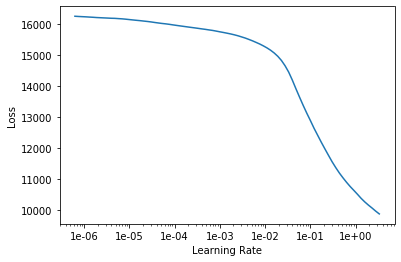

In [22]:
learn.lr_find()
learn.recorder.plot()

Train for 3 epochs with superconvergence.

In [23]:
learn.fit_one_cycle(3, 1e-1)

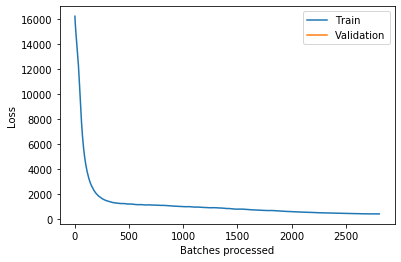

In [24]:
learn.recorder.plot_losses()

### Visual verification of predictions

In [25]:
def to_img(y):
    img = y.data.cpu().numpy().astype('int').reshape(28,28)
    return img
    
def plot(y, y_hat): 
    plt.figure()

    si = 1
    for i in range(3):
        plt.subplot(3, 2, si)
        plt.imshow(to_img(y[i]))
        plt.axis('off')
        si += 1

        plt.subplot(3, 2, si)
        plt.imshow(to_img(y_hat[i]))
        plt.axis('off')
        si += 1

    plt.show()

Take a minibatch from the training dataset, and push it through the network.

Plot the ground truth, and the predicted value of some samples.

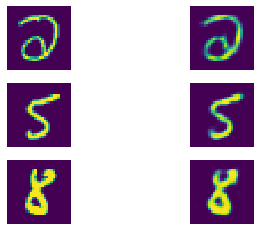

In [26]:
(cat_x,cont_x),y = next(iter(data.train_dl))
y_hat = learn.model.forward(cat_x, cont_x)

plot(y, y_hat)

### Save model

In [27]:
learn.save("mnist-embedding-autoencoder.model")

In [28]:
ae = learn.load("mnist-embedding-autoencoder.model", device='cuda:0')

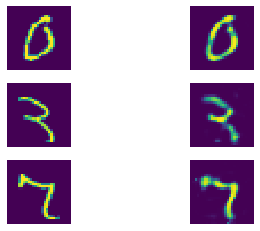

In [29]:
(cat_x,cont_x),y = next(iter(data.train_dl))
y_hat = ae.model.forward(cat_x, cont_x)
plot(y, y_hat)

### Remove decoder

In [30]:
ae.model.layers.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=20932, out_features=5000, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=5000, out_features=1000, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=50, bias=True)
  (7): ReLU(inplace=True)
  (8): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=50, out_features=784, bias=True)
  (10): SigmoidRange()
)>

In [37]:
nn.Sequential(*list(ae.model.layers)[:7])

Sequential(
  (0): Linear(in_features=20932, out_features=5000, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=5000, out_features=1000, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1000, out_features=50, bias=True)
)

In [38]:
ae.model.layers = nn.Sequential(*list(ae.model.layers)[:7])

In [39]:
(cat_x,cont_x),y = next(iter(data.train_dl))
y_hat = ae.model.forward(cat_x, cont_x)

In [40]:
y_hat.shape

torch.Size([64, 50])

In [41]:
ae.save("mnist-embedding-encoder.model")

In [42]:
ae.export(file="mnist-embedding-encoder.inference")

### Inference

In [43]:
ae.data.add_test(tl)

In [44]:
preds = ae.get_preds(ds_type=DatasetType.Test)

In [45]:
encoded_preds = preds[0].cpu().numpy()
encoded_preds.shape

(60000, 50)

## Visualization with ground truth labels

### T-SNE

Clustering on the output of t-SNE: https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne


Question: Should I Run Clustering on PCA or t-SNE Components: https://www.biostars.org/p/411630/

In [46]:
time_start = time.time()
# tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000, early_exaggeration=12, n_iter_without_progress=1000)
tsne_results = tsne.fit_transform(encoded_preds)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.282s...
[t-SNE] Computed neighbors for 60000 samples in 454.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for 

T-SNE takes a lot of time (784 seconds), so let's save it.

In [182]:
np.save("t-sne", tsne_results)

and load  it when needed

In [186]:
tsne_results = np.load("t-sne.npy")

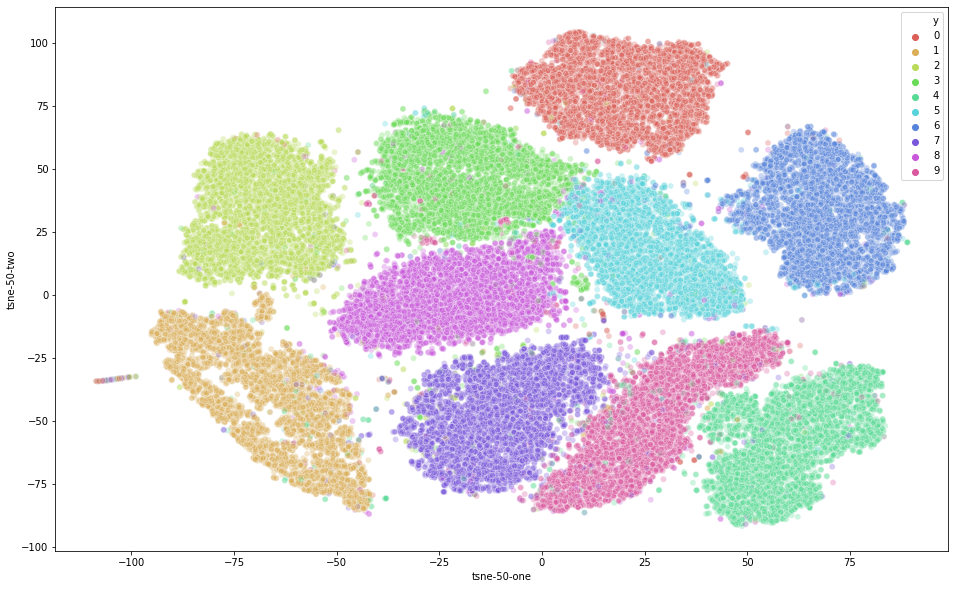

In [187]:
df_tsne = df.copy()
df_tsne['tsne-50-one'] = tsne_results[:,0]
df_tsne['tsne-50-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-50-one", y="tsne-50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_tsne,
    legend="full",
    alpha=0.3
)


### UMAP

In [194]:
standard_embedding = umap.UMAP(random_state=41).fit_transform(encoded_preds)

/home/koen/apps/anaconda3/envs/fastai/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../apps/anaconda3/envs/fastai/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


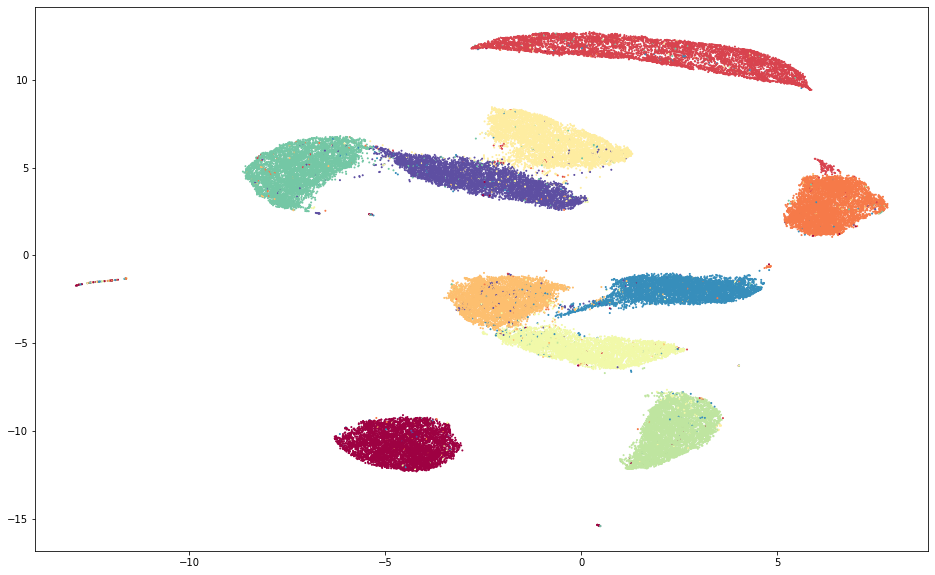

In [195]:
plt.figure(figsize=(16,10))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df.y, s=1, cmap='Spectral');

## Clustering
### UMAP + HDBSCAN

https://umap-learn.readthedocs.io/en/latest/clustering.html

In [172]:
clusterable_embedding = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(encoded_preds)

/home/koen/apps/anaconda3/envs/fastai/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../apps/anaconda3/envs/fastai/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [339]:
labels = hdbscan.HDBSCAN(
    min_samples=15,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)


In [348]:
print("number of clusters found: " + str(labels.max()+1))

number of clusters found: 10


In [341]:
df_yc = pd.DataFrame(df['y'])
df_yc['cluster'] = labels

cdf = pd.DataFrame(df_yc.groupby(['y', 'cluster']).size()).reset_index()
cdf.columns = ['y', 'cluster', 'c_count']
cdf = cdf.sort_values('c_count', ascending=False).head(10).sort_values('y')
cdf['y_count'] = df.groupby('y').size().values
cdf['error'] = cdf['y_count'] - cdf['c_count']
cdf['epct'] = cdf['error'] / cdf['c_count']
cdf

,y,cluster,c_count,y_count,error,epct
4,0,3,5823,5923,100,0.017173
10,1,2,6619,6742,123,0.018583
18,2,0,5798,5958,160,0.027596
37,3,9,5911,6131,220,0.037219
45,4,6,5640,5842,202,0.035816
57,5,8,5203,5421,218,0.041899
61,6,1,5822,5918,96,0.016489
72,7,4,6092,6265,173,0.028398
86,8,7,5535,5851,316,0.057091
95,9,5,5732,5949,217,0.037858


In [349]:
accuracy = (cdf['y_count'].sum() - cdf['error'].sum()) / cdf['y_count'].sum()
print("accuracy: " + str(accuracy))

accuracy: 0.9695833333333334


Labeled as unknown (cluster = -1):

In [358]:
df_yc[df_yc['cluster'] == -1].groupby('y').size()

y
0    53
2    35
3    29
4    13
5    38
6    16
7     8
8    63
9    16
dtype: int64

#### Visualization predicted clusters
##### T-SNE

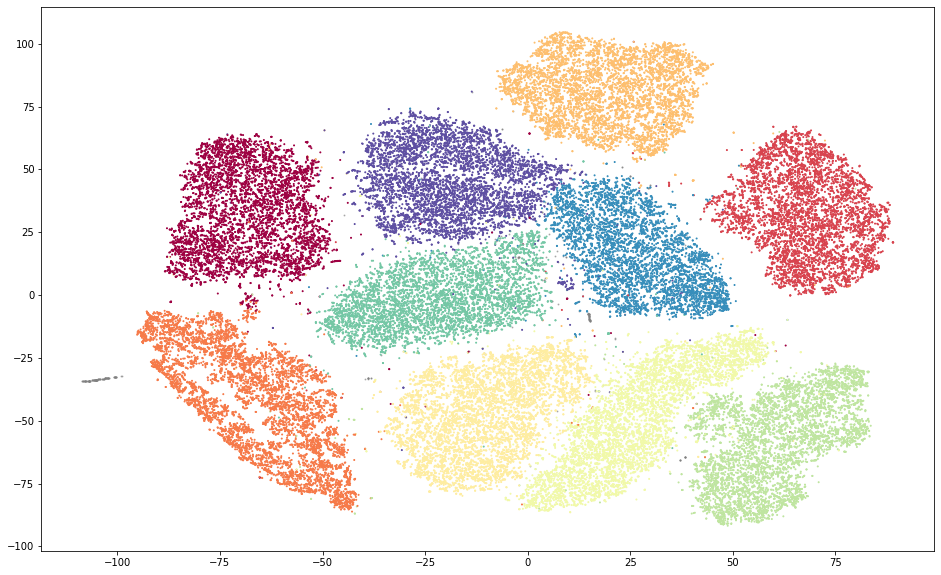

In [354]:
plt.figure(figsize=(16,10))
clustered = (labels >= 0)
plt.scatter(tsne_results[~clustered, 0],
            tsne_results[~clustered, 1],
            c=[(0.5, 0.5, 0.5)],
            s=1,
            alpha=0.5)
plt.scatter(tsne_results[clustered, 0],
            tsne_results[clustered, 1],
            c=labels[clustered],
            s=1,
            cmap='Spectral');

##### UMAP

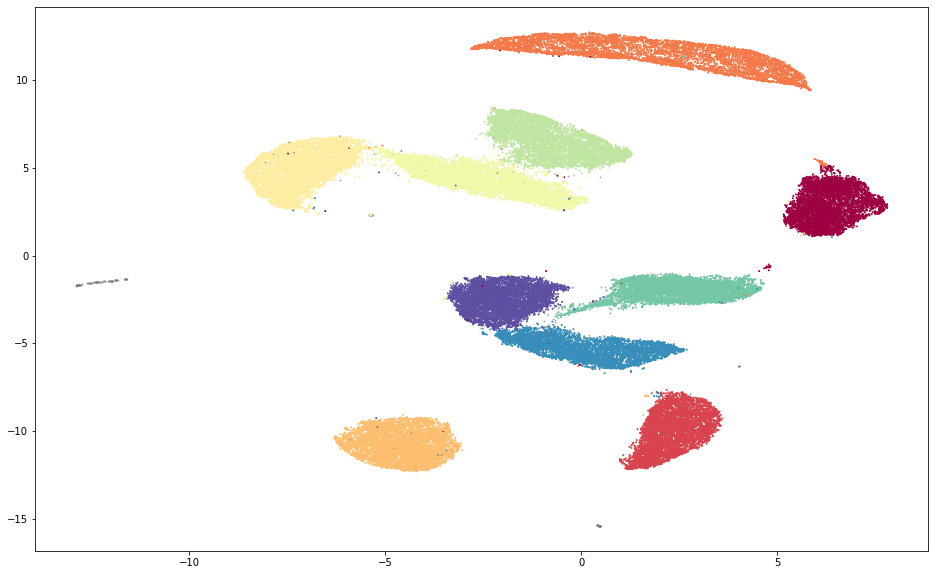

In [351]:
plt.figure(figsize=(16,10))
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=[(0.5, 0.5, 0.5)],
            s=1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=1,
            cmap='Spectral');

#### HDBSCAN directly on encoded features (no dimensionality reduction) 

In [153]:
X = encoded_preds
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500)
cluster_labels = clusterer.fit_predict(X)

In [154]:
print(clusterer.labels_.max())

8


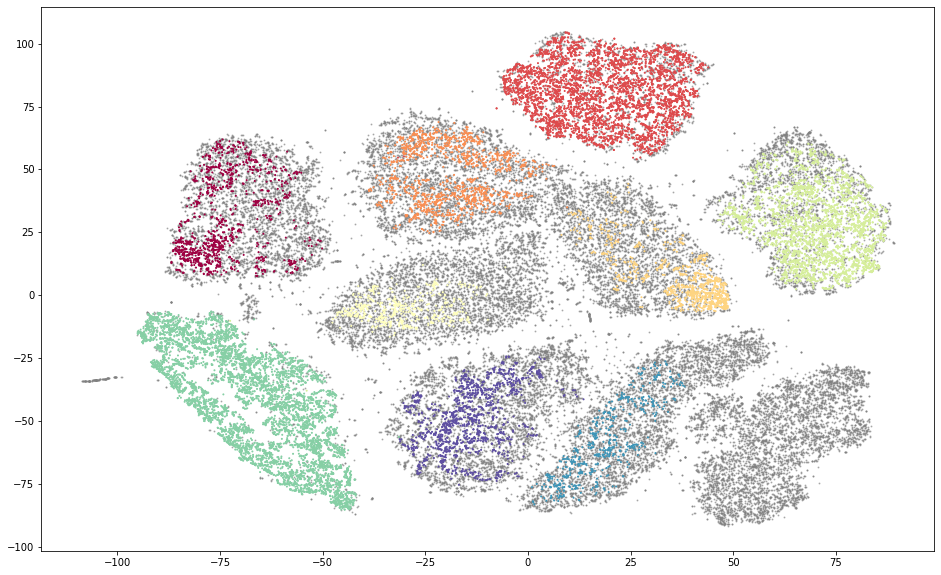

In [361]:
plt.figure(figsize=(16,10))
hdbscan_labels = cluster_labels
clustered = (hdbscan_labels >= 0)
plt.scatter(tsne_results[~clustered, 0],
            tsne_results[~clustered, 1],
            c=[(0.5, 0.5, 0.5)],
            s=1,
            alpha=0.5)
plt.scatter(tsne_results[clustered, 0],
            tsne_results[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

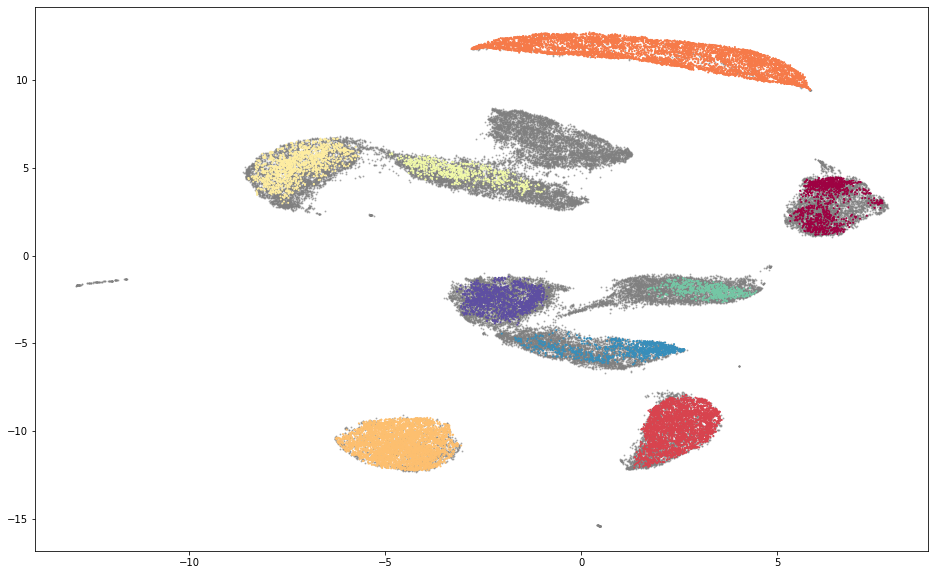

In [360]:
plt.figure(figsize=(16,10))
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=[(0.5, 0.5, 0.5)],
            s=1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=1,
            cmap='Spectral');

#### K-Means

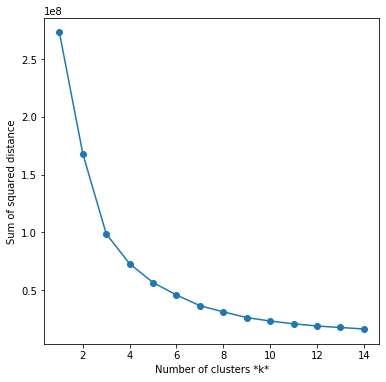

In [63]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 15))
X = tsne_results

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [107]:
X = tsne_results
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X)
y_kmeans = kmeans.predict(X)

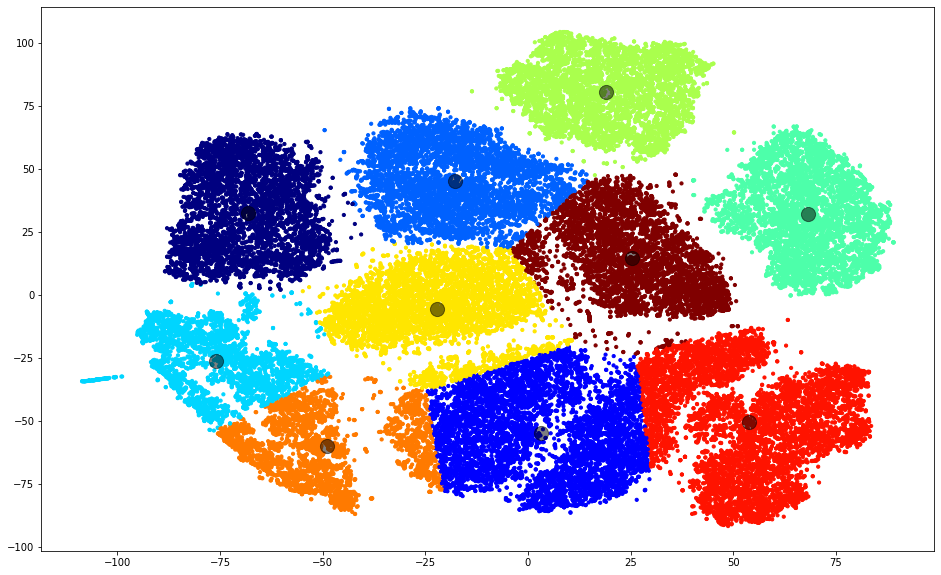

In [108]:
plt.figure(figsize=(16,10))

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='jet')

#sns.scatterplot(
#    x="tsne-50-one", y="tsne-50-two",
#    hue=y_kmeans,
#    data=df_tsne,
#    legend="full",
#    alpha=0.3
#)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

#### Spectral clustering

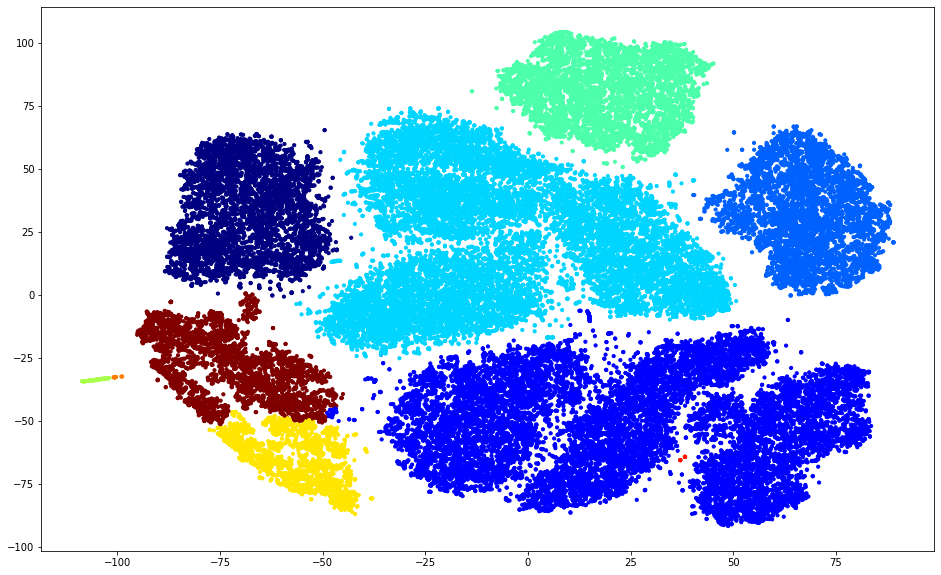

In [74]:
X = tsne_results
spectral = SpectralClustering(
    n_clusters=10, 
    eigen_solver='arpack',
    affinity="nearest_neighbors")
spectral.fit(X)
plt.figure(figsize=(16,10))
labels = spectral.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='jet')

In [50]:
encoded_preds.shape

(60000, 50)

In [51]:
X = encoded_preds
kmeans = KMeans(n_clusters=10, random_state=0)
df_tsne['clusters'] = kmeans.fit_predict(X)
df_tsne['clusters'].groupby(df_tsne['clusters']).count()

clusters
0    59913
1        1
2        3
3        5
4        1
5       17
6        6
7       44
8        9
9        1
Name: clusters, dtype: int64

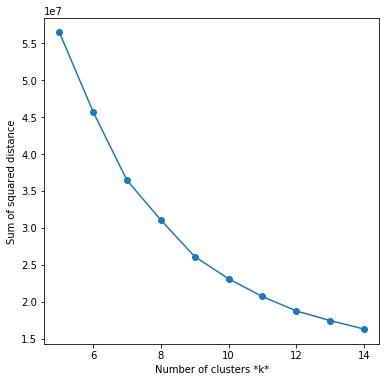

In [62]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(5, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

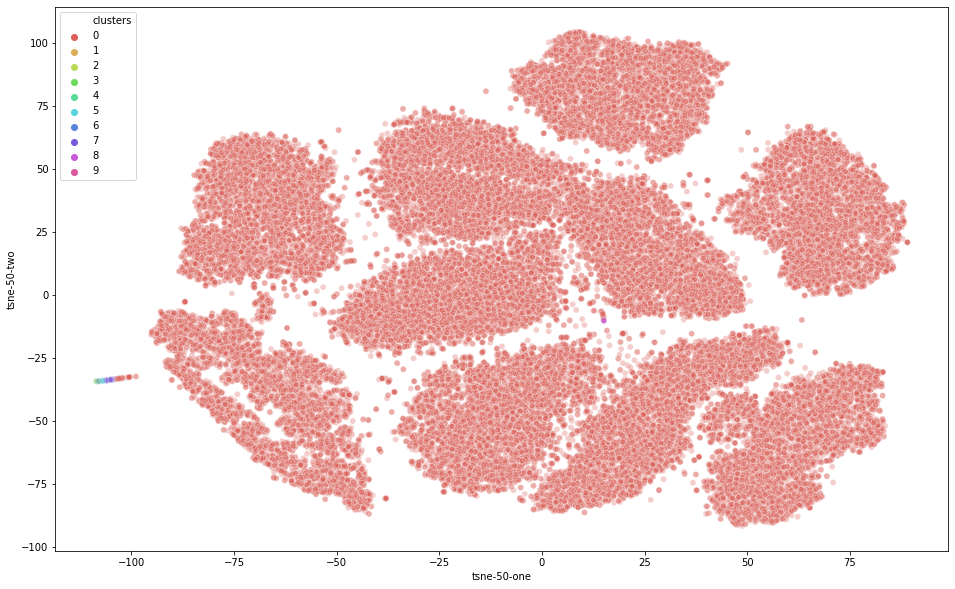

In [52]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-50-one", y="tsne-50-two",
    hue="clusters",
    palette=sns.color_palette("hls", 10),
    data=df_tsne,
    legend="full",
    alpha=0.3
)
